<a href="https://colab.research.google.com/github/LoujineAlrifaei/BachelorThesis/blob/main/Data_clustering_thesis_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

No elbow found. Calculating Gap Statistic...
Selected k = 10 using Gap Statistic.

Final Metrics for k = 10
Davies-Bouldin Index: 0.0731
Silhouette Score: 0.8867
WCSS: 732678.7597


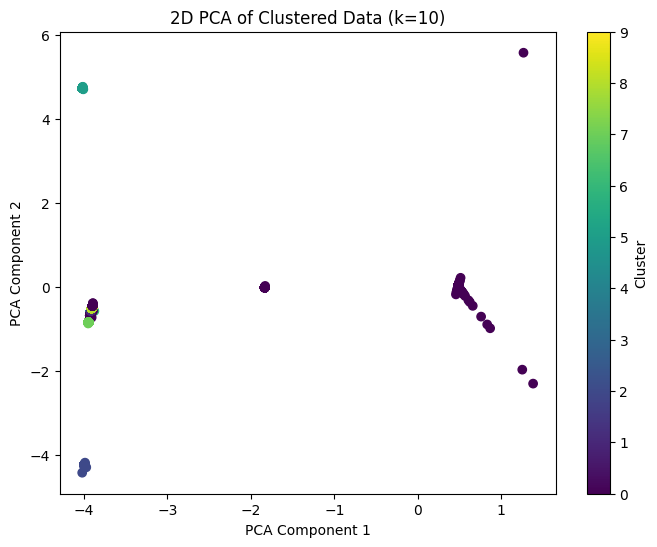

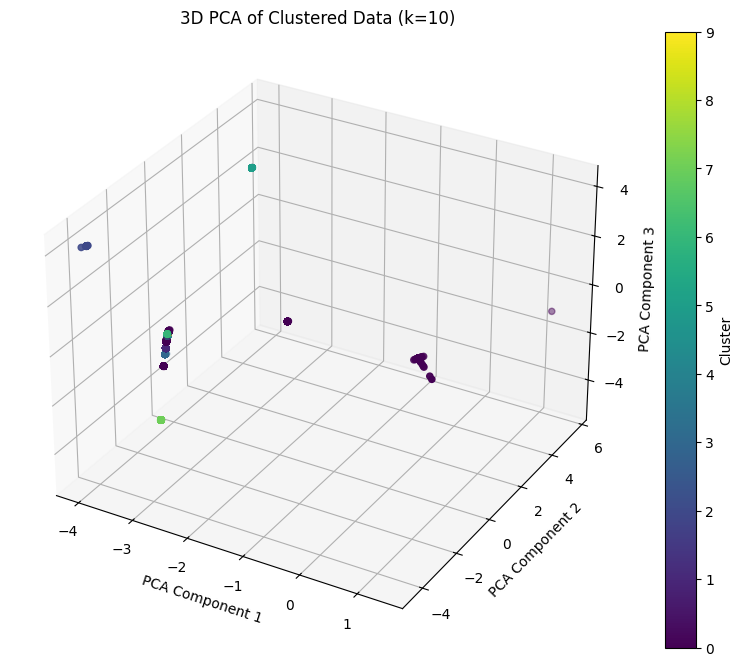

In [ ]:
!pip install kneed

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.preprocessing import OneHotEncoder

from sklearn.utils import resample
from scipy.spatial.distance import cdist
import random

# Gap Statistic function
def compute_gap_statistic(data, n_refs=10, max_clusters=10):
    shape = data.shape
    tops = data.max(axis=0)
    bottoms = data.min(axis=0)
    rands = np.zeros((n_refs, shape[0], shape[1]))
    for i in range(n_refs):
        for j in range(shape[1]):
            rands[i, :, j] = np.random.uniform(bottoms[j], tops[j], size=shape[0])

    gaps = []
    for k in range(2, max_clusters + 1):
        km = KMeans(n_clusters=k, random_state=42)
        km.fit(data)
        orig_disp = np.mean(np.min(cdist(data, km.cluster_centers_, 'euclidean'), axis=1))

        ref_disps = np.zeros(n_refs)
        for i in range(n_refs):
            km.fit(rands[i])
            ref_disp = np.mean(np.min(cdist(rands[i], km.cluster_centers_, 'euclidean'), axis=1))
            ref_disps[i] = ref_disp

        gap = np.log(np.mean(ref_disps)) - np.log(orig_disp)
        gaps.append(gap)

    optimal_k = np.argmax(gaps) + 2
    return optimal_k, gaps


# Load and clean data
file_path = "/content/OnlineRetail.csv"
df = pd.read_csv(file_path, encoding='ISO-8859-1')

financial_columns = ['Quantity', 'UnitPrice']
non_financial_columns = ['InvoiceNo', 'StockCode', 'Description', 'InvoiceDate', 'CustomerID', 'Country']

cleaned_financial_data = df[financial_columns].dropna()
cleaned_non_financial_data = df[non_financial_columns].dropna()

sample_data_size = 45000
sampled_financial_data = cleaned_financial_data.sample(n=sample_data_size, random_state=42).reset_index(drop=True)
sampled_non_financial_data = cleaned_non_financial_data.reset_index(drop=True).loc[sampled_financial_data.index].reset_index(drop=True)

encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_non_financial_data = encoder.fit_transform(sampled_non_financial_data[['Country']])
encoded_non_financial_df = pd.DataFrame(encoded_non_financial_data, columns=encoder.get_feature_names_out(['Country']))
sampled_non_financial_data = sampled_non_financial_data.drop('Country', axis=1)
sampled_non_financial_data = pd.concat([sampled_non_financial_data, encoded_non_financial_df], axis=1)

combined_data = np.hstack([sampled_financial_data, encoded_non_financial_data])
scaler = StandardScaler()
normalized_data = scaler.fit_transform(combined_data)

# Elbow & Silhouette method
k_range = range(2, 11)
wcss_values = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_data)
    wcss_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(normalized_data, kmeans.labels_))

kl = KneeLocator(list(k_range), wcss_values, curve='convex', direction='decreasing')
elbow_k = kl.elbow
silhouette_best_k = k_range[np.argmax(silhouette_scores)]
if elbow_k is None:
    print("No elbow found. Calculating Gap Statistic...")
    gap_k, gaps = compute_gap_statistic(normalized_data, n_refs=5, max_clusters=10)
    final_k = gap_k
    print(f"Selected k = {final_k} using Gap Statistic.")
else:
    print(f"Elbow k: {elbow_k}, Silhouette-best k: {silhouette_best_k}")
    if elbow_k != silhouette_best_k:
        final_k = silhouette_best_k
        print(f"Selected k = {final_k} based on highest silhouette score.")
    else:
        final_k = elbow_k
        print(f"Selected k = {final_k} based on Elbow method.")
kmeans = KMeans(n_clusters=final_k, random_state=42)
kmeans.fit(normalized_data)
labels = kmeans.labels_

# Metrics
db_index = davies_bouldin_score(normalized_data, labels)
sil_score = silhouette_score(normalized_data, labels)

print(f"\nFinal Metrics for k = {final_k}")
print(f"Davies-Bouldin Index: {db_index:.4f}")
print(f"Silhouette Score: {sil_score:.4f}")
print(f"WCSS: {kmeans.inertia_:.4f}")

# Plot WCSS and Silhouette
if elbow_k is not None:
    fig, ax1 = plt.subplots(figsize=(8, 6))
    ax1.plot(k_range, wcss_values, marker='o', color='blue', label='WCSS')
    ax1.set_xlabel('Number of Clusters (K)')
    ax1.set_ylabel('WCSS', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.plot(k_range, silhouette_scores, marker='o', color='green', label='Silhouette Score')
    ax2.set_ylabel('Silhouette Score', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    fig.suptitle('WCSS and Silhouette Score vs K')
    fig.tight_layout()
    plt.show()

# PCA Visualization
pca = PCA(n_components=3)
pca_data = pca.fit_transform(normalized_data)

# 2D
plt.figure(figsize=(8, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels, cmap='viridis')
plt.colorbar(label='Cluster')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title(f'2D PCA of Clustered Data (k={final_k})')
plt.show()

# 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_data[:, 0], pca_data[:, 1], pca_data[:, 2], c=labels, cmap='viridis')
fig.colorbar(scatter, label='Cluster')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title(f'3D PCA of Clustered Data (k={final_k})')
plt.show()


Elbow k: 6, Silhouette-best k: 6
Selected k = 6

Final Metrics for k = 6
Davies-Bouldin Index: 0.4508
Silhouette Score: 0.7037
WCSS: 506.7892


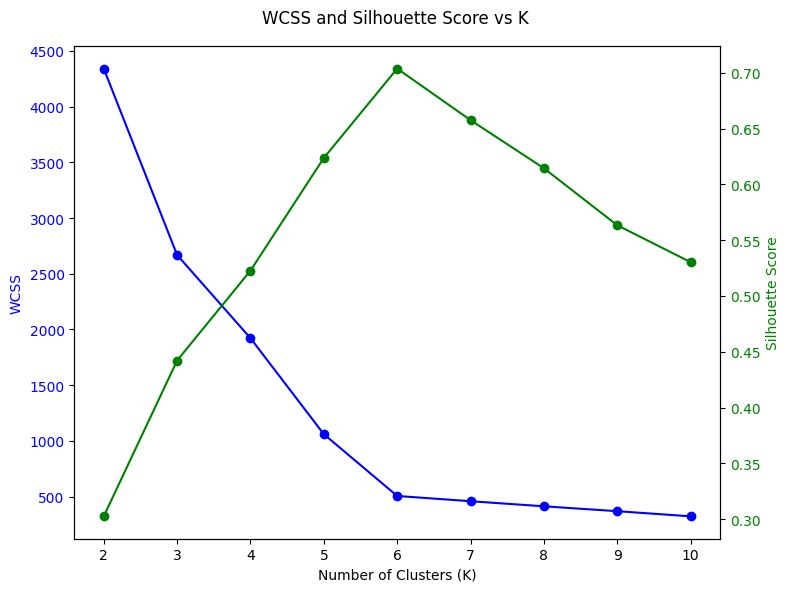

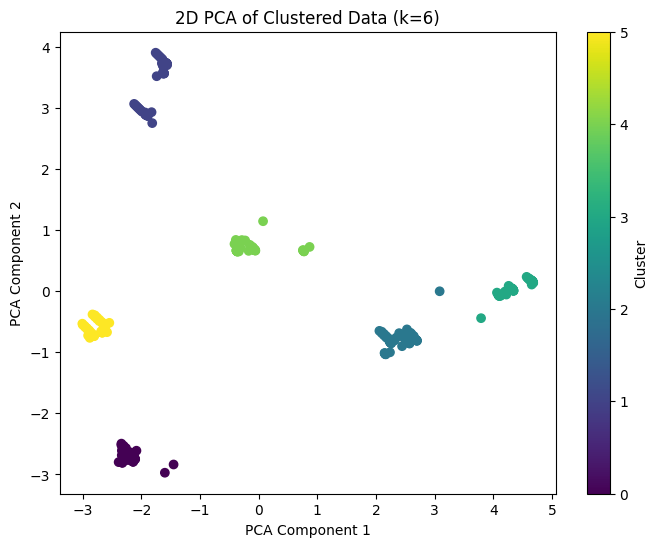

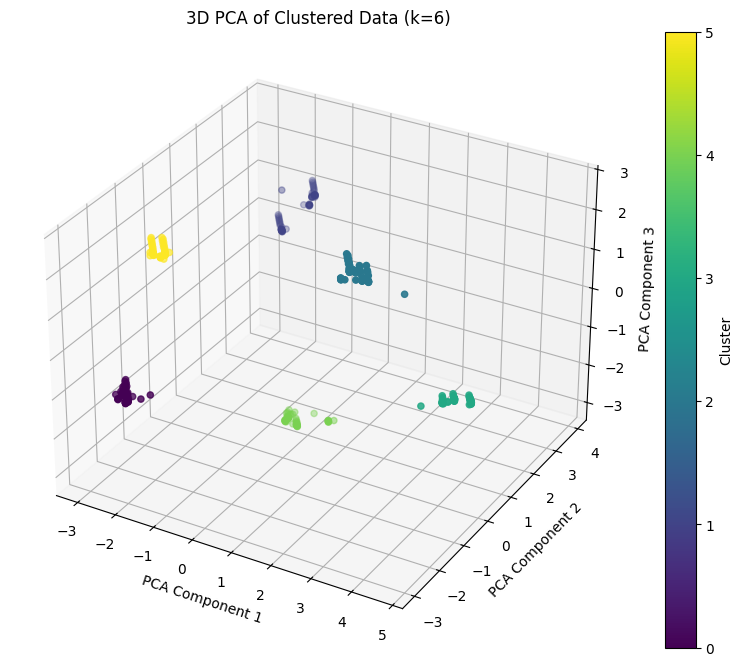

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.impute import SimpleImputer
from scipy.spatial.distance import cdist

# Gap Statistic Function
def compute_gap_statistic(data, n_refs=10, max_clusters=10):
    shape = data.shape
    tops = data.max(axis=0)
    bottoms = data.min(axis=0)

    rands = np.zeros((n_refs, shape[0], shape[1]))
    for i in range(n_refs):
        for j in range(shape[1]):
            rands[i, :, j] = np.random.uniform(bottoms[j], tops[j], size=shape[0])

    gaps = []
    for k in range(2, max_clusters + 1):
        km = KMeans(n_clusters=k, random_state=42)
        km.fit(data)
        orig_disp = np.mean(np.min(cdist(data, km.cluster_centers_, 'euclidean'), axis=1))

        ref_disps = np.zeros(n_refs)
        for i in range(n_refs):
            km.fit(rands[i])
            ref_disp = np.mean(np.min(cdist(rands[i], km.cluster_centers_, 'euclidean'), axis=1))
            ref_disps[i] = ref_disp

        gap = np.log(np.mean(ref_disps)) - np.log(orig_disp)
        gaps.append(gap)

    optimal_k = np.argmax(gaps) + 2
    return optimal_k, gaps
file_path = "/content/E-commerce Customer Behavior - Sheet1.csv"
df = pd.read_csv(file_path)
numerical_columns = [
    'Age', 'Total Spend', 'Items Purchased', 'Average Rating', 'Days Since Last Purchase'
]
categorical_columns = [
    'Gender', 'City', 'Membership Type', 'Discount Applied', 'Satisfaction Level'
]

for col in numerical_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
imputer_numerical = SimpleImputer(strategy='median')
imputer_categorical = SimpleImputer(strategy='most_frequent')

df[numerical_columns] = imputer_numerical.fit_transform(df[numerical_columns])
df[categorical_columns] = imputer_categorical.fit_transform(df[categorical_columns])
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_categorical_data = encoder.fit_transform(df[categorical_columns])
encoded_categorical_df = pd.DataFrame(encoded_categorical_data, columns=encoder.get_feature_names_out(categorical_columns))
df_cleaned = df.drop(columns=categorical_columns)
df_cleaned = pd.concat([df_cleaned, encoded_categorical_df], axis=1)
scaler = StandardScaler()
normalized_data = scaler.fit_transform(df_cleaned)

# Elbow and Silhouette Method
k_range = range(2, 11)
wcss_values = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_data)
    wcss_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(normalized_data, kmeans.labels_))

kl = KneeLocator(list(k_range), wcss_values, curve='convex', direction='decreasing')
elbow_k = kl.elbow
silhouette_best_k = k_range[np.argmax(silhouette_scores)]

if elbow_k is None:
    print("No elbow found. Using Gap Statistic...")
    gap_k, gaps = compute_gap_statistic(normalized_data, n_refs=5, max_clusters=10)
    final_k = gap_k
    print(f"Selected k = {final_k} using Gap Statistic.")
else:
    print(f"Elbow k: {elbow_k}, Silhouette-best k: {silhouette_best_k}")
    final_k = silhouette_best_k if elbow_k != silhouette_best_k else elbow_k
    print(f"Selected k = {final_k}")

kmeans = KMeans(n_clusters=final_k, random_state=42)
kmeans.fit(normalized_data)
labels = kmeans.labels_

# Metrics
db_index = davies_bouldin_score(normalized_data, labels)
sil_score = silhouette_score(normalized_data, labels)

print(f"\nFinal Metrics for k = {final_k}")
print(f"Davies-Bouldin Index: {db_index:.4f}")
print(f"Silhouette Score: {sil_score:.4f}")
print(f"WCSS: {kmeans.inertia_:.4f}")

# Plot WCSS & Silhouette
if elbow_k is not None:
    fig, ax1 = plt.subplots(figsize=(8, 6))
    ax1.plot(k_range, wcss_values, marker='o', color='blue', label='WCSS')
    ax1.set_xlabel('Number of Clusters (K)')
    ax1.set_ylabel('WCSS', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.plot(k_range, silhouette_scores, marker='o', color='green', label='Silhouette Score')
    ax2.set_ylabel('Silhouette Score', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    fig.suptitle('WCSS and Silhouette Score vs K')
    fig.tight_layout()
    plt.show()

# PCA 2D Plot
pca = PCA(n_components=3)
pca_data = pca.fit_transform(normalized_data)

plt.figure(figsize=(8, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels, cmap='viridis')
plt.colorbar(label='Cluster')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title(f'2D PCA of Clustered Data (k={final_k})')
plt.show()

# PCA 3D Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_data[:, 0], pca_data[:, 1], pca_data[:, 2], c=labels, cmap='viridis')
fig.colorbar(scatter, label='Cluster')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title(f'3D PCA of Clustered Data (k={final_k})')
plt.show()
